## mimlsvm

mi = mulit-instance
ml = multi-label
svm = svm

As described in Shen et al 2009: http://ieeexplore.ieee.org/document/5346261/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import nltk
import os
import joblib
import re
import pickle
import sklearn
import sys
import string

import warnings

from nltk import TextTilingTokenizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler,MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.svm import SVC

from joblib import Parallel, delayed

from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [3]:
%aimport src.data.movielens_20m_imdb
%aimport src.helpers.labels,src.helpers.neighbours, src.helpers.segments,src.helpers.embeddings
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics, src.utils.distances, src.utils.plotting

In [4]:
from src.data.movielens_20m_imdb import load_df_or_get_from_cache
from src.helpers.labels import truncate_labels
from src.helpers.segments import make_distance_matrix_for_segments,vectorize_segments
from src.helpers.embeddings import read_glove_wiki_weighted

from src.utils.dataframes import sample_rows
from src.utils.metrics import ranking
from src.utils.clusters import k_medoids
from src.utils.distances import hausdorff
from src.utils.plotting import plot_micro_f1_at_k

In [5]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/movielens-mimlsvm-embeddings/")
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/movielens-ml20m-imdb/")
PATH_TO_PROCESSED_FILE = os.path.abspath('../../../data/processed/movielens-20m-imdb-tags-and-synopses-2017-12-20.csv')

# CONFIGS

SEED= 42
W=20 # Pseudosentence size (in words) - not specified in the paper, taken from TextTiling default values
K=10 # Size (in sentences) of the block used in the block comparison method - not specified in the paper, taken from TextTiling default values
MAX_NB_WORDS=500
NB_COMPONENTS=100
SAMPLE_FRAC=0.3

In [ ]:
docs_df = load_df_or_get_from_cache(PATH_TO_PROCESSED_FILE,INTERIM_DATA_ROOT)

In [ ]:
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [ ]:
docs_df['sentences'] = docs_df['synopsis'].map(lambda row: sentence_tokenizer.tokenize(row))

In [ ]:
%%time
docs_df['num_sentences'] = docs_df['sentences'].map( lambda sents: len(sents))

In [ ]:
docs_df.head()

In [ ]:
docs_df.iloc[0]['sentences'][:5]

In [ ]:
docs_df.describe()

In [ ]:
tok = TextTilingTokenizer(w=W, k=K)

In [ ]:
def extract_segments(candidates):
    
    try:
        # we must manually insert "\n\n" because this is how 
        # texttilingtokenizer requires candidate boundaries to be 
        # represented.
        segments = tok.tokenize("\n\n".join(candidates))
    except ValueError:
        # this happens when the candidate list is too small for the 
        # text tiling tokenizer to be able to find segments. so just return
        # the original sentences.
        segments= candidates
        
    # now remove the artificially added chars
    segments = [segment.replace("\n\n"," ").strip() for segment in segments]
    
    return segments

In [10]:
if os.path.isfile(INTERIM_DATA_ROOT+"/docs_df_with_segments-{}.p".format(MAX_NB_WORDS)):
    print('cache hit')
    docs_df = pickle.load(open(INTERIM_DATA_ROOT+"/docs_df_with_segments-{}.p".format(MAX_NB_WORDS),"rb"))
else:
    docs_df['segments'] = docs_df['sentences'].map(lambda candidates: extract_segments(candidates))
    pickle.dump(docs_df,open(INTERIM_DATA_ROOT+"/docs_df_with_segments-{}.p".format(MAX_NB_WORDS),"wb"))

cache hit


### sample for grid search

In [ ]:
sample_df = docs_df.sample(int(SAMPLE_FRAC*len(docs_df)))

In [ ]:
segments = sample_df['segments'].values
documents = sample_df['synopsis'].values
labels = sample_df["tags"].map(lambda tagstring: tagstring.split(","))

In [ ]:
labels = truncate_labels(labels,10)

In [ ]:
# segments, documents and labelsets are defined outside of the parameterGrid loop
# because they're the same for every configuration    
segments_train, segments_val, documents_train, documents_val, Y_train, Y_val = train_test_split(segments,
                                                                                               documents,
                                                                                               labels,
                                                                                               test_size=0.15)

mlb = MultiLabelBinarizer()
mlb.fit(labels)

Y_train = mlb.transform(Y_train)
Y_val = mlb.transform(Y_val)

print('total number of train documents: {}'.format(len(documents_train)))
print('total number of validation documents: {}'.format(len(documents_val)))
print("total number of unique tags: {} ".format(len(mlb.classes_)))

### it doesn't work if I use TfIdfVectorizer!!!!!

In [ ]:
vectorizer = CountVectorizer(max_features=MAX_NB_WORDS)

# TRAINING SET
vectorizer.fit(documents_train)
tfidf_segments_train = vectorize_segments(segments_train, vectorizer)
tfidf_segments_val = vectorize_segments(segments_val, vectorizer)

In [ ]:
X_train_vec = vectorizer.transform(documents_train)
lda = LatentDirichletAllocation(n_components=NB_COMPONENTS, learning_method='online',verbose=1)
lda.fit(X_train_vec)

In [ ]:
lda.perplexity(vectorizer.transform(documents_train))

In [ ]:
lda.perplexity(vectorizer.transform(documents_val))

In [ ]:
X_train_lda_segments = list()

for document_segments in tfidf_segments_train:
    lda_segments = np.array([lda.transform(segment) for segment in document_segments])
    
    # need axis=1 otherwise documents with a single segment become (100,)
    X_train_lda_segments.append(lda_segments.squeeze(axis=1))

In [ ]:
X_val_lda_segments = list()

for document_segments in tfidf_segments_val:
    lda_segments = np.array([lda.transform(segment) for segment in document_segments])
    
    # need axis=1 otherwise documents with a single segment become (100,)
    X_val_lda_segments.append(lda_segments.squeeze(axis=1))

In [ ]:
def make_distance_matrix_for_lda_segments(vectorized_segments, distance='hausdorff'):
    """
    Returns the distance matrix for the documents having the given segments.

    :param vectorized_segments: array of size M, where each element is a "bag" of segments: matrix of
        shape (*,NUM_FEATURES), and each row on this matrix is the TF-IDF vector for one segment.
    :param distance: how to compare the two bags
    :return: pairwise distance matrix (MxM matrix)
    """
    if distance.lower().strip() != 'hausdorff':
        raise Exception("Only 'hausdorff' distance supported right now.")

    num_samples = len(vectorized_segments)

    distance_function = lambda a, b: hausdorff(a, b)

    distance_matrix = np.zeros((num_samples, num_samples))

    for i, segments_for_document_a in enumerate(vectorized_segments):
        for j, segments_for_document_b in enumerate(vectorized_segments):
            distance = distance_function(segments_for_document_a, segments_for_document_b)
            distance_matrix[i][j] = distance

    return distance_matrix

In [ ]:
%%time

path_to_cache = INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm-lda/distance-matrix-train-sample-{}.p".format(SAMPLE_FRAC)

if os.path.isfile(path_to_cache):
    print('cache hit')
    dist_matrix_train = pickle.load(open(path_to_cache,"rb"))
else:
    print('Fitting distance matrix')
    dist_matrix_train = make_distance_matrix_for_lda_segments(X_train_lda_segments)
    pickle.dump(dist_matrix_train, open(path_to_cache, "wb"))

In [6]:
def make_train_dataset(distance_matrix, medoid_indices):
    """
    Returns a matrix where element Aij contains the distance from sample i to medoid j.

    :param distance_matrix: MxM matrix with pairwise distances
    :param medoid_indices: array of length N containing the indices of the medoids for each cluster
    :return: distances to medoids (MxN matrix)
    """

    return distance_matrix[:,medoid_indices]

In [7]:
def make_validation_dataset(source_vectorized_segments, medoid_vectorized_segments):
    """
    Calculates the distances from every source_document (reprsented by its segments) to every medoid
    document (also represented by its segments) using the hausdorff distance.
    
    Returns a matrix where element Aij contains the distance from sample i to medoid j.

    :param source_vectorized_segments: array of length M, where each element is a matrix with one row
        for every segment in a source document
    :param medoid_vectorized_segments: array of length N where each element is a matrix with one row
        for every segment in a medoid document
    :return: distances to medoids (MxN matrix)
    """
    
    num_val_samples = len(source_vectorized_segments)
    num_medoids = len(medoid_vectorized_segments)
    
    val_dataset = np.zeros((num_val_samples,num_medoids))    
    
    for i,source_segments in enumerate(source_vectorized_segments):
        for j,medoid_segments in enumerate(medoid_vectorized_segments):
            val_dataset[i][j] = hausdorff(source_segments,medoid_segments)
            
    return np.array(val_dataset)

In [ ]:
# calculating medoids
NORMALIZATION = ['standard','minmax',None] # not specified in the paper
SAMPLE_TO_NB_MEDOIDS_RATIO = [0.2,0.3,0.4] # not specified in the paper, but taken from MIMLSVM canonical implementation
# classification
SVM_KERNEL=['rbf','linear','poly'] # not specified in the paper, but taken from MIMLSVM canonical implementation
SVM_GAMMA=['auto'] # not specified in the paper, but taken from MIMLSVM canonical implementation
SVM_C= [0.1,1,10,20,40,60]# not specified in the paper, but taken from MIMLSVM canonical implementation
SVM_DEGREE=[3,4]

In [ ]:
grid_search_parameters = [
    {
        'medoid_normalization':  NORMALIZATION,
        'svm_kernel': ['poly'],
        'svm_c':SVM_C,
        'svm_degree' :SVM_DEGREE,
        'svm_gamma':SVM_GAMMA,
        'nb_medoids_ratio': SAMPLE_TO_NB_MEDOIDS_RATIO
    }
]

In [ ]:
print('total number of configurations to test: {}'.format(len(ParameterGrid(grid_search_parameters))))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

for (i,configuration) in tqdm(enumerate(ParameterGrid(grid_search_parameters))):
                 
    # nb_medoids depends upon the dataset length
    ratio = configuration['nb_medoids_ratio']
    nb_medoids = int(len(documents_train) * ratio)
    
    # these are the document segments to be used as medoids
    medoids_indices_train = k_medoids(dist_matrix_train,nb_medoids)[0]

    # a matrix where element Aij contains the distance from sample i to medoid j.
    X_train = make_train_dataset(dist_matrix_train,medoids_indices_train)
    
    # VALIDATION SET

    fitted_medoids = list()
    for medoid_index in medoids_indices_train:
        fitted_medoids.append(X_train_lda_segments[medoid_index]) 
    
    X_val = make_validation_dataset(X_val_lda_segments,fitted_medoids)     
        
    svm = SVC(kernel=configuration['svm_kernel'],
            gamma=configuration['svm_gamma'],
            C=configuration['svm_c'],
            degree=configuration['svm_degree'])
    
    clf = OneVsRestClassifier(CalibratedClassifierCV(svm,cv=2),n_jobs=-1)        

    if configuration['medoid_normalization'] == 'standard':      
        scaler = StandardScaler()
        X_train_final = scaler.fit_transform(X_train)
        X_val_final = scaler.transform(X_val)
    elif configuration['medoid_normalization'] == 'minmax':
        scaler = MinMaxScaler()
        X_train_final = scaler.fit_transform(X_train)
        X_val_final = scaler.transform(X_val)
    else:
        X_train_final = X_train
        X_val_final = X_val
    
    # y_train was defined outside the loop    
    clf.fit(X_train,Y_train)
    
    
    # validation score
    Y_pred_val = clf.predict_proba(X_val)  
    
    print("iter: {}, configuration: {}\n".format(i,configuration))
    
    ks = [1,2,3,4,5,6,7,8,9,10]

    for k in ks:
        print("validation micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=k,normalize=True)))    

### train the final model on the full data, using the victor parameters

winning params:iter: 78, configuration: {'nb_medoids_ratio': 0.4, 'svm_kernel': 'poly', 'medoid_normalization': None, 'svm_gamma': 'auto', 'svm_c': 10, 'svm_degree': 3}

In [11]:
np.random.seed(42)
SAMPLE_FRAC=0.7
docs_df = docs_df.sample(int(SAMPLE_FRAC*len(docs_df)))

segments = docs_df['segments'].values
documents = docs_df['synopsis'].values
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))

labels = truncate_labels(labels,10)

In [12]:
np.random.seed(42)

# segments, documents and labelsets are defined outside of the parameterGrid loop
# because they're the same for every configuration    
segments_train, segments_val, documents_train, documents_val, Y_train, Y_val = train_test_split(segments,
                                                                                               documents,
                                                                                               labels,
                                                                                               test_size=0.15)

mlb = MultiLabelBinarizer()
mlb.fit(labels)

Y_train = mlb.transform(Y_train)
Y_val = mlb.transform(Y_val)

print('total number of train documents: {}'.format(len(documents_train)))
print('total number of validation documents: {}'.format(len(documents_val)))
print("total number of unique tags: {} ".format(len(mlb.classes_)))

total number of train documents: 3992
total number of validation documents: 705
total number of unique tags: 1547 


In [13]:
vectorizer = CountVectorizer(max_features=MAX_NB_WORDS)

# TRAINING SET
vectorizer.fit(documents_train)
tfidf_segments_train = vectorize_segments(segments_train, vectorizer)
tfidf_segments_val = vectorize_segments(segments_val, vectorizer)

In [14]:
X_train_vec = vectorizer.transform(documents_train)
lda = LatentDirichletAllocation(n_components=NB_COMPONENTS, learning_method='online',verbose=1)
lda.fit(X_train_vec)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=100, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [15]:
lda.perplexity(vectorizer.transform(documents_train))

130.87649878248007

In [16]:
lda.perplexity(vectorizer.transform(documents_val))

142.15987725866162

In [17]:
X_train_lda_segments = list()

for document_segments in tfidf_segments_train:
    lda_segments = np.array([lda.transform(segment) for segment in document_segments])
    
    # need axis=1 otherwise documents with a single segment become (100,)
    X_train_lda_segments.append(lda_segments.squeeze(axis=1))

In [18]:
X_val_lda_segments = list()

for document_segments in tfidf_segments_val:
    lda_segments = np.array([lda.transform(segment) for segment in document_segments])
    
    # need axis=1 otherwise documents with a single segment become (100,)
    X_val_lda_segments.append(lda_segments.squeeze(axis=1))

In [19]:
%%time

path_to_cache = INTERIM_DATA_ROOT+"/mimlsvm/mimlsvm-lda/distance-matrix-train-sample-{}.p".format(SAMPLE_FRAC)

if os.path.isfile(path_to_cache):
    print('cache hit')
    dist_matrix_train = pickle.load(open(path_to_cache,"rb"))
else:
    print('Fitting distance matrix')
    dist_matrix_train = make_distance_matrix_for_lda_segments(X_train_lda_segments)
    pickle.dump(dist_matrix_train, open(path_to_cache, "wb"))

cache hit
CPU times: user 16 ms, sys: 36 ms, total: 52 ms
Wall time: 53 ms


In [20]:
# let's just also add a couple higher values of C just to make sure
# that deosn't help
# {'nb_medoids_ratio': 0.4, 'svm_kernel': 'poly', 'medoid_normalization': None, 'svm_gamma': 'auto', 'svm_c': 10, 'svm_degree': 3}
victor_parameters = [
    {
        'medoid_normalization':  [None],
        'svm_kernel': ['poly'],
        'svm_c':[1,5,10,15,20],
        'svm_degree' :[3],
        'svm_gamma':['auto'],
        'nb_medoids_ratio': [0.4]
    }
]

In [21]:
print('total number of configurations to test: {}'.format(len(ParameterGrid(victor_parameters))))

total number of configurations to test: 5


### set winning parameters and train on the whole dataset

In [22]:
import warnings
warnings.filterwarnings('ignore')

for (i,configuration) in tqdm(enumerate(ParameterGrid(victor_parameters))):
                 
    # nb_medoids depends upon the dataset length
    ratio = configuration['nb_medoids_ratio']
    nb_medoids = int(len(documents_train) * ratio)
    
    # these are the document segments to be used as medoids
    medoids_indices_train = k_medoids(dist_matrix_train,nb_medoids)[0]

    # a matrix where element Aij contains the distance from sample i to medoid j.
    X_train = make_train_dataset(dist_matrix_train,medoids_indices_train)
    
    # VALIDATION SET

    fitted_medoids = list()
    for medoid_index in medoids_indices_train:
        fitted_medoids.append(X_train_lda_segments[medoid_index]) 
    
    X_val = make_validation_dataset(X_val_lda_segments,fitted_medoids)     
        
    svm = SVC(kernel=configuration['svm_kernel'],
            gamma=configuration['svm_gamma'],
            C=configuration['svm_c'],
            degree=configuration['svm_degree'])
    
    clf = OneVsRestClassifier(CalibratedClassifierCV(svm,cv=2),n_jobs=-1)        

    if configuration['medoid_normalization'] == 'standard':      
        scaler = StandardScaler()
        X_train_final = scaler.fit_transform(X_train)
        X_val_final = scaler.transform(X_val)
    elif configuration['medoid_normalization'] == 'minmax':
        scaler = MinMaxScaler()
        X_train_final = scaler.fit_transform(X_train)
        X_val_final = scaler.transform(X_val)
    else:
        X_train_final = X_train
        X_val_final = X_val
    
    # y_train was defined outside the loop    
    clf.fit(X_train,Y_train)
    
    
    # validation score
    Y_pred_val = clf.predict_proba(X_val)  
    
    print("iter: {}, configuration: {}\n".format(i,configuration))
    
    ks = [1,2,3,4,5,6,7,8,9,10]
                                                                                                                                                
    for k in ks:
        print("validation micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=k,normalize=True)))    

0it [00:00, ?it/s]

iter: 0, configuration: {'svm_c': 1, 'nb_medoids_ratio': 0.4, 'medoid_normalization': None, 'svm_kernel': 'poly', 'svm_gamma': 'auto', 'svm_degree': 3}

validation micro-F1 @1: 0.2375
validation micro-F1 @2: 0.22306238185255198
validation micro-F1 @3: 0.21518987341772153
validation micro-F1 @4: 0.20267686424474188
validation micro-F1 @5: 0.19230769230769232
validation micro-F1 @6: 0.18998716302952504
validation micro-F1 @7: 0.1889908256880734
validation micro-F1 @8: 0.18269695505074915


1it [27:27, 1647.53s/it]

validation micro-F1 @9: 0.1764621353642765
validation micro-F1 @10: 0.17096899727591128


KeyboardInterrupt: 

In [ ]:
ks = [1,2,3,4,5,6,7,8,9,10]

for k in ks:
#         print("train micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_train,Y_pred_train,k=k,normalize=True)))
    print("validation micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=k,normalize=True))) 

## save the final model

In [ ]:
pickle.dump(clf, open(MODELS_ROOT.rstrip('/')+"/model.p", "wb"))

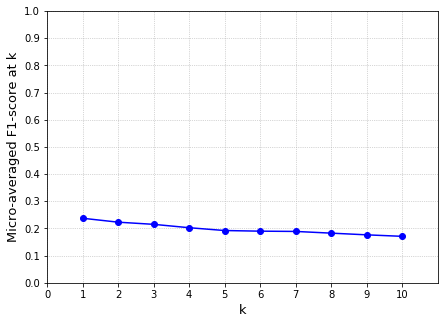

In [23]:
plt.clf()
img = plt.gcf()
ax = plt.gca()
validation_scores = [
0.2375, 0.223062,
0.2151, 0.202676,
0.19230769, 0.1899871,
0.1889908, 0.1826969,
0.1764621, 0.1709689]
plot_micro_f1_at_k(validation_scores,ax)
plt.gcf().set_size_inches(7,5)
plt.gca().legend_.remove()
plt.show()